# Trabajo Práctico 3: Detectando atributos de personas.

## Integrantes: Cravero, Ulises y Pautasso, L. Nicolás.
## Tema: CS:GO Professional Matches.

### Imports y configs

In [36]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# para descargar los datasets desde kaggle
import opendatasets as od

# para dividir el dataset
import os
import shutil
import pandas as pd
import random

### Descarga de datos

#### Descargamos el dataset desde Kaggle:

In [2]:
# descargamos el dataset correspondiente desde Kaggle
od.download("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1.33G/1.33G [01:42<00:00, 14.0MB/s]


#### Dividimos las imágenes en directorios dependiendo a que conjunto de datos pertenece

In [3]:
# ruta del directorio donde se descargaron las imágenes
directory = "./celeba-dataset/img_align_celeba/img_align_celeba"

# creamos las carpetas de destino
output_directory = "./partitions"
os.makedirs(output_directory, exist_ok=True)

# leemos el archivo de las particiones de las imagenes
list_partition = pd.read_csv("./celeba-dataset/list_eval_partition.csv")

# filtramos y movemos las imágenes a las carpetas correspondientes (0 = train, 1 = validation y 2 = test)
for index, row in list_partition.iterrows():
    image_id = row['image_id']
    partition = row['partition']
    source_path = os.path.join(directory, f"{image_id}")
    destination_path = os.path.join(output_directory, str(partition), f"{image_id}")
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    shutil.copyfile(source_path, destination_path)

#### Instanciamos las variables que contienen cada conjunto de datos dependiendo el path que obtuvimos antes

In [ ]:
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./partition/0')
VALIDATION_DIR = Path('./partition/1')
TEST_DIR = Path('./partition/2')

#### Previsualizamos los datos que contiene nuestro dataset para ver y definir cuales puede ser importantes mantener en base a cierta relación que tengan con la variable a predecir (si tiene barba o no)

In [37]:
list_attributes = pd.read_csv('./celeba-dataset/list_attr_celeba.csv')
list_attributes.columns = list_attributes.columns.str.lower()
print('Columnas en el dataset: ', list_attributes.columns)

#por el momento vamos a usar todas pero podriamos borrar las blurry por ejemplo

Columnas en el dataset:  Index(['image_id', '5_o_clock_shadow', 'arched_eyebrows', 'attractive',
       'bags_under_eyes', 'bald', 'bangs', 'big_lips', 'big_nose',
       'black_hair', 'blond_hair', 'blurry', 'brown_hair', 'bushy_eyebrows',
       'chubby', 'double_chin', 'eyeglasses', 'goatee', 'gray_hair',
       'heavy_makeup', 'high_cheekbones', 'male', 'mouth_slightly_open',
       'mustache', 'narrow_eyes', 'no_beard', 'oval_face', 'pale_skin',
       'pointy_nose', 'receding_hairline', 'rosy_cheeks', 'sideburns',
       'smiling', 'straight_hair', 'wavy_hair', 'wearing_earrings',
       'wearing_hat', 'wearing_lipstick', 'wearing_necklace',
       'wearing_necktie', 'young'],
      dtype='object')


#### Armamos los datasets dividiendo imagenes por un lado (entradas) y salidas por el otro (atributos)

In [38]:
# Rutas de los directorios de imágenes
train_directory = "./partitions/0"
validation_directory = "./partitions/1"
test_directory = "./partitions/2"

# Diccionario para almacenar los atributos de cada imagen
image_attributes = {}

# Iterar sobre cada fila del DataFrame 'listattrib'
for index, row in list_attributes.iterrows():
    image_id = row['image_id']
    attributes = {
        '5_o_clock_shadow': "row['5_o_clock_shadow']",
        'arched_eyebrows': "row['arched_eyebrows']",
        'attractive': "row['attractive']",
        'bags_under_eyes': "row['bags_under_eyes']",
        'bald': "row['bald']",
        'bangs': "row['bangs']",
        'big_lips': "row['big_lips']",
        'big_nose': "row['big_nose']",
        'black_hair': "row['black_hair']",
        'blond_hair': "row['blond_hair']",
        'blurry': "row['blurry']",
        'brown_hair': "row['brown_hair']",
        'bushy_eyebrows': "row['bushy_eyebrows']",
        'chubby': "row['chubby']",
        'double_chin': "row['double_chin']",
        'eyeglasses': "row['eyeglasses']",
        'goatee': "row['goatee']",
        'gray_hair': "row['gray_hair']",
        'heavy_makeup': "row['heavy_makeup']",
        'high_cheekbones': "row['high_cheekbones']",
        'male': "row['male']",
        'mouth_slightly_open': "row['mouth_slightly_open']",
        'mustache': "row['mustache']",
        'narrow_eyes': "row['narrow_eyes']",
        'no_beard': "row['no_beard']",
        'oval_face': "row['oval_face']",
        'pale_skin': "row['pale_skin']",
        'pointy_nose': "row['pointy_nose']",
        'receding_hairline': "row['receding_hairline']",
        'rosy_cheeks': "row['rosy_cheeks']",
        'sideburns': "row['sideburns']",
        'smiling': "row['smiling']",
        'straight_hair': "row['straight_hair']",
        'wavy_hair': "row['wavy_hair']",
        'wearing_earrings': "row['wearing_earrings']",
        'wearing_hat': "row['wearing_hat']",
        'wearing_lipstick': "row['wearing_lipstick']",
        'wearing_necklace': "row['wearing_necklace']",
        'wearing_necktie': "row['wearing_necktie']",
        'young': "row['young']"
    }
    image_attributes[image_id] = attributes

# Función para obtener el conjunto de imágenes y atributos asociados
def get_images_and_attributes(image_directory):
    images = []
    attributes = []
    image_files = os.listdir(image_directory)
    for filename in image_files:
        image_path = os.path.join(image_directory, filename)
        images.append(image_path)
        attributes.append(image_attributes[filename])
    return images, attributes

# Obtener las imágenes y atributos del conjunto de entrenamiento
train_images, train_attributes = get_images_and_attributes(train_directory)

# Obtener las imágenes y atributos del conjunto de validación
validation_images, validation_attributes = get_images_and_attributes(validation_directory)

# Obtener las imágenes y atributos del conjunto de prueba
test_images, test_attributes = get_images_and_attributes(test_directory)


### Análisis exploratorio sobre el conjunto de datos

#### Cantidad de datos por set, muestreo y caracteristicas de las imágenes:

NÚMERO DE IMÁGENES EN TRAIN: 162770
NÚMERO DE IMÁGENES EN VALIDATION: 19867
NÚMERO DE IMÁGENES EN TEST: 19962


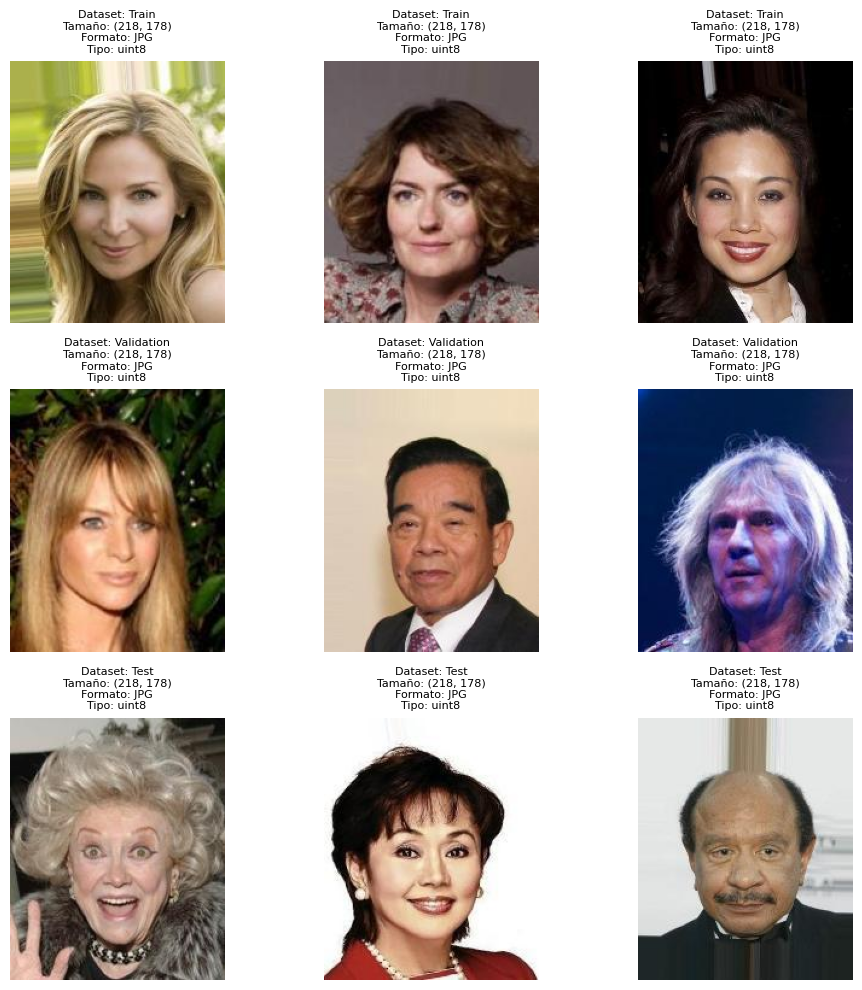

In [68]:
# Rutas de los directorios que contienen las imágenes
directorios = ['./partitions/0', './partitions/1', './partitions/2']
nombre_set = ['train', 'validation', 'test']

# Mostrar una cuadrícula de 3x3
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Iterar sobre los directorios
for i, directorio in enumerate(directorios):
    # Obtener la lista de archivos del directorio
    archivos = os.listdir(directorio)
    print("NÚMERO DE IMÁGENES EN " + nombre_set[i].upper() +":", len(archivos))
    # Elegir tres imágenes aleatorias
    muestras = random.sample(archivos, 3)
    # Iterar sobre las muestras y mostrar las imágenes
    for j, muestra in enumerate(muestras):
        ruta_imagen = os.path.join(directorio, muestra)
        # Leer la imagen y mostrarla
        img = plt.imread(ruta_imagen)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        # Obtener características de la imagen
        tamano = img.shape[:2]
        formato = muestra.split('.')[-1].upper()
        tipo = img.dtype
        axs[i, j].set_title(f"Dataset: {nombre_set[i].capitalize()}\nTamaño: {tamano}\nFormato: {formato}\nTipo: {tipo}", fontsize=8)
    
    
# Ajustar el espacio entre las imágenes
plt.tight_layout()

# Mostrar el gráfico con las imágenes
plt.show()

#### Distribución de la variable de salida ('no_beard'):

Número de imágenes sin barba: 169158
Número de imágenes con barba: 33441


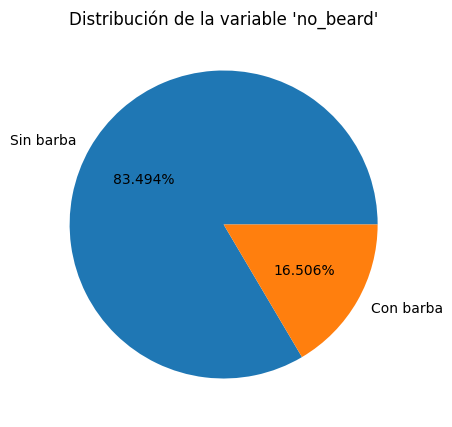

In [59]:
# Obtenemos la cantidad de valores mayores y menores que 0
no_beard = (list_attributes['no_beard'] == 1).sum()
yes_beard = (list_attributes['no_beard'] == -1).sum()

print(f'Número de imágenes sin barba: {no_beard}')
print(f'Número de imágenes con barba: {yes_beard}')

# Creamos un gráfico de torta de la distribución de los valores positivos y negativos de kddiff, mostrando los porcentajes con tres decimales (por el gran balanceo que existe)
plt.figure(figsize=(5, 5))
plt.pie([no_beard, yes_beard], labels=['Sin barba', 'Con barba'], autopct='%1.3f%%')
plt.title("Distribución de la variable 'no_beard'")

plt.show()